In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
#! sudo pip3 install kaggle 

In [4]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [4]:
path = Config.data_path()/'dog_breed'
#path.mkdir(parents=True, exist_ok=True)

In [5]:
#! conda install -y -c haasad eidl7zip

In [6]:
#! kaggle competitions download -c dog-breed-identification -f sample_submission.csv -p {path}  
#! unzip -q -n {path}/sample_submission.csv.zip -d {path}

In [7]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/dog_breed/models'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/test'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/train'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/test.zip'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/mode_temp_pth'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/sample_submission.csv'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/labels.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/labels.csv'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/sample_submission.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/train.zip'),
 PosixPath('/home/jupyter/.fastai/data/dog_breed/train_320_320')]

In [8]:
tfms = get_transforms(do_flip = True, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
src = ImageDataBunch.from_csv(path, folder='train', size=224, suffix='.jpg', sep = ' ', ds_tfms=tfms)

In [10]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in path 'train' folder
        .random_split_by_pct(0.2)
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(sep=' ')
        #How to label? -> use the csv file
        .transform(tfms, size = 224))
        #Data augmentation? -> use tfms with a size of 224                       

In [11]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

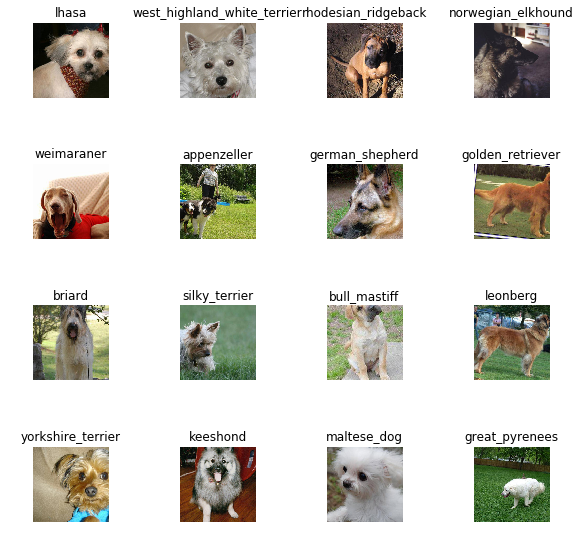

In [12]:
data.show_batch(rows=4, figsize=(8,8))

## The Model
First, use resnet34 to train the model

In [13]:
arch = models.resnet34

In [14]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


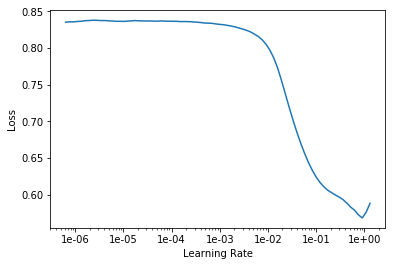

In [16]:
learn.recorder.plot()

In [17]:
lr = 0.02

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.121036,0.018415,0.993913,0.548049
2,0.025772,0.012758,0.994749,0.712460
3,0.016217,0.009880,0.995776,0.794151
4,0.011901,0.008898,0.996257,0.809713
5,0.009605,0.008174,0.996522,0.831481


In [19]:
learn.save('stage-1-rn34')

## Update the image size and train the model using resnet 101

In [15]:
data = (src.transform(tfms, size=299)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 299, 299])

In [16]:
arch = models.resnet101

In [17]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

In [23]:
learn.freeze()

In [24]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


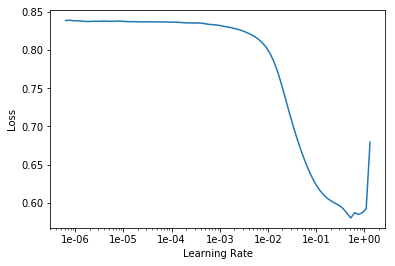

In [25]:
learn.recorder.plot()

## train the model
I train the model for one iteration using the Resnet101, the accuracy rate is 89%. 

In [26]:
lr = 0.02

In [27]:
learn.fit_one_cycle(5, slice(lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.321608,0.037444,0.991744,0.012231
2,0.040900,0.011225,0.996196,0.811032
3,0.013789,0.007619,0.997081,0.867108
4,0.008802,0.006173,0.997546,0.888014
5,0.007234,0.005849,0.997693,0.892985


In [28]:
learn.save('stage-1-rn101')

## fine-tune the model by unfreezing the last 10 layers and train again

In [29]:
learn.freeze_to(91)

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


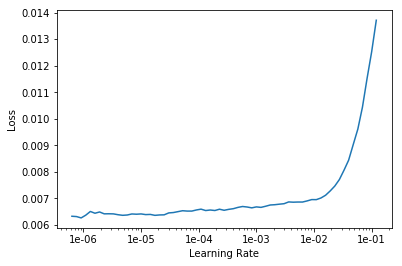

In [31]:
learn.recorder.plot()

In [32]:
lr = 1e-02 #looks like the learning rate starts to increase at 1e-05. Use 1e-5

In [72]:
learn.fit_one_cycle(5, slice(1e-5, lr/4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.005327,0.005009,0.997856,0.904540
2,0.005259,0.005053,0.997876,0.903248
3,0.005048,0.005134,0.998092,0.897062
4,0.004807,0.005021,0.997905,0.901337
5,0.004943,0.005009,0.997961,0.902024


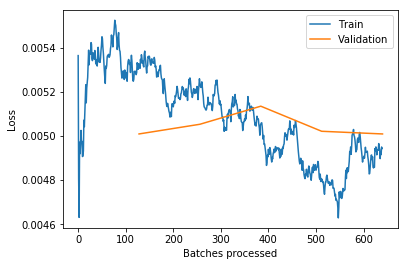

In [73]:
learn.recorder.plot_losses()

In [74]:
learn.save('stage-2-rn101')